<a href="https://colab.research.google.com/github/fraboeni/fraboeni.github.io/blob/master/tensorflow_privacy_membership_inference_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A simple example on doing Membership Inference Attacks with TensorFlow Privacy

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy import special

# tensorflow imports
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
# install the most recent verson of tensorflow-privacy
!pip install -U git+https://github.com/tensorflow/privacy


  Cloning https://github.com/tensorflow/privacy to /tmp/pip-req-build-wh0h7aoe
  Running command git clone -q https://github.com/tensorflow/privacy /tmp/pip-req-build-wh0h7aoe
  Created wheel for tensorflow-privacy: filename=tensorflow_privacy-0.5.1-cp36-none-any.whl size=163260 sha256=85475bc01616b81e1eb6902f36fdf1525a7c667bd8a6a8fd0d320a707907fcd9
  Stored in directory: /tmp/pip-ephem-wheel-cache-zayf3wby/wheels/8a/e4/14/41d16468ac11ec804bd21cfb75fc2e24f96b9e4c5af778f576
Successfully built tensorflow-privacy
  Found existing installation: tensorflow-privacy 0.2.2
    Uninstalling tensorflow-privacy-0.2.2:
      Successfully uninstalled tensorflow-privacy-0.2.2


In [3]:
# tensorflow-privacy 
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

## Some helper methods

In [4]:
def load_cifar10():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing CIFAR10 dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.cifar10.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # cifar10 labels come one-hot encoded, there
  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()

  return train_data, train_labels, test_data, test_labels
 
def make_simple_model():
  """ Define a Keras model without much of regularization
  Such a model is prone to overfitting"""
  shape = (32, 32, 3)
  i = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(i)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  # if we don't specify an activation for the last layer, we can have the logits
  x = Dense(10)(x)
  model = Model(i, x)
  return model

In [5]:
train_data, train_labels, test_data, test_labels = load_cifar10()

170500096/170498071 [==============================] - 2s 0us/step


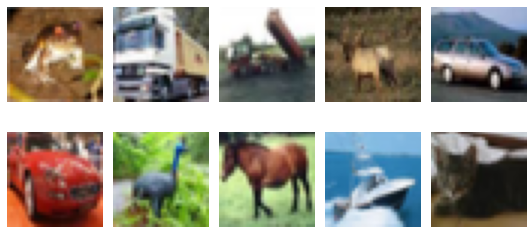

In [6]:
# show some train data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(train_data[i])

plt.tight_layout()
plt.show()

In [7]:
# make the neural network model with the function specified above.
# one model is supposed to train for 10, one for 50 epochs
model = make_simple_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0     

In [8]:
# specify parameters
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Model Training
Train the model for 30 epochs. 

The idea is that we can use the TensorFlow Privacy Library on the trained models in order to quantify the membership inference risk respectively. 


In [9]:
# train the model
history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=128, 
                       epochs=30)

Epoch 1/30
391/391 [==============================] - 10s 7ms/step - loss: 1.9234 - accuracy: 0.2833 - val_loss: 1.4616 - val_accuracy: 0.4671
Epoch 2/30
391/391 [==============================] - 2s 5ms/step - loss: 1.4021 - accuracy: 0.4911 - val_loss: 1.2609 - val_accuracy: 0.5543
Epoch 3/30
391/391 [==============================] - 2s 5ms/step - loss: 1.2261 - accuracy: 0.5601 - val_loss: 1.2069 - val_accuracy: 0.5694
Epoch 4/30
391/391 [==============================] - 2s 5ms/step - loss: 1.1536 - accuracy: 0.5923 - val_loss: 1.1129 - val_accuracy: 0.6083
Epoch 5/30
391/391 [==============================] - 2s 5ms/step - loss: 1.0677 - accuracy: 0.6211 - val_loss: 1.0724 - val_accuracy: 0.6231
Epoch 6/30
391/391 [==============================] - 2s 5ms/step - loss: 1.0049 - accuracy: 0.6478 - val_loss: 1.0696 - val_accuracy: 0.6279
Epoch 7/30
391/391 [==============================] - 2s 5ms/step - loss: 0.9540 - accuracy: 0.6636 - val_loss: 0.9807 - val_accuracy: 0.6577
Epoch

(0.0, 1.0)

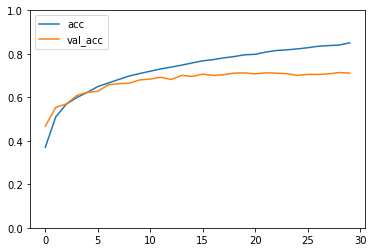

In [10]:
# plot accuracy for the first model
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

### Attack on the model

In [11]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = model.predict(train_data)
print('Predict on test...')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


In [12]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

In [13]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [14]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

In [15]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [16]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 2889 training and 2889 test examples) achieved an AUC of 0.69 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 2889 training and 2889 test examples) achieved an advantage of 0.31 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an AUC of 0.59
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an advantage of 0.16

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.64
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.24

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.60
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage 

Figure(432x288)


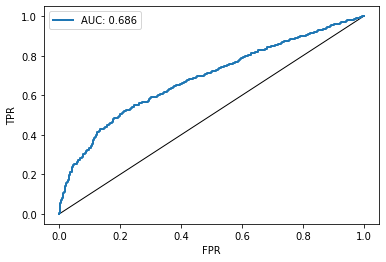

In [20]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))